In [77]:
# Import modul yang diperlukan
import sys
import os

# Menambahkan path ke sistem agar bisa mengakses modul dari dua folder di atas direktori saat ini
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

# Import pustaka yang diperlukan untuk menyimpan dan memuat data
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Import pustaka untuk machine learning
from sklearn.ensemble import RandomForestClassifier  # Model klasifikasi Random Forest
from sklearn.model_selection import train_test_split  # Fungsi untuk membagi dataset menjadi training dan testing
from sklearn.metrics import accuracy_score  # Fungsi untuk mengukur akurasi model


In [79]:
# Mendefinisikan variabel yang menunjukkan jenis dataset
mimic_type = 4

# Mengecek apakah jenis dataset adalah MIMIC-III (mimic_type == 3)
if mimic_type == 3:
    print('####  LOAD DATA MIMIC-III ####')  # Menampilkan pesan bahwa data MIMIC-III akan dimuat
    
    # Memuat file pickle yang berisi data tabel MIMIC-III
    with open('../../data/step_4_start.pkl', 'rb') as file:
        MIMICtable = pickle.load(file)  # Memuat objek data dari file pickle
    
    # Memuat data training, validation, dan testing untuk MIMIC-III
    train = np.load('../../data/train.npy')  # Data training
    validat = np.load('../../data/validation.npy')  # Data validasi
    test = np.load('../../data/test.npy')  # Data testing
else:
    print('####  LOAD DATA MIMIC-IV ####')  # Menampilkan pesan bahwa data MIMIC-IV akan dimuat
    
    # Memuat file pickle yang berisi data tabel MIMIC-IV
    with open('../../data/step_4_start_mimiciv.pkl', 'rb') as file:
        MIMICtable = pickle.load(file)  # Memuat objek data dari file pickle
    
    # Memuat data training, validation, dan testing untuk MIMIC-IV
    train = np.load('../../data/train_mimiciv.npy')  # Data training MIMIC-IV
    validat = np.load('../../data/validation_mimiciv.npy')  # Data validasi MIMIC-IV
    test = np.load('../../data/test_mimiciv.npy')  # Data testing MIMIC-IV


####  PARAMETER SETTINGS  ####
####  LOAD DATA MIMIC-IV ####


In [81]:
# Membuat salinan dari MIMICtable untuk memproses data
df = MIMICtable.copy()

# Menghapus kolom yang tidak informatif (identifikasi dan timestamp)
drop_columns = ['bloc', 'stay_id', 'charttime', 'died_within_48h_of_out_time', 'mortality_90d', 'delay_end_of_record_and_discharge_or_death']  # Kolom identifikasi dan waktu
df = df.drop(columns=drop_columns)  # Menghapus kolom yang tidak diperlukan

# Menentukan target variabel (misalnya, "died_in_hosp" sebagai label mortalitas)
target_col = "died_in_hosp"  # Ubah jika diperlukan
X = df.drop(columns=[target_col])  # Fitur (semua kolom selain target)
y = df[target_col]  # Target variabel (mortalitas)

# Membagi dataset menjadi data pelatihan dan pengujian (80% pelatihan, 20% pengujian)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Melatih model Random Forest dengan 100 pohon keputusan dan skor OOB (out-of-bag)
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(X_train, y_train)  # Melatih model dengan data pelatihan

# Mendapatkan ranking fitur berdasarkan pentingnya setiap fitur
feature_importances = rf.feature_importances_  # Mendapatkan nilai pentingnya fitur
feature_ranking = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})  # Menyimpan dalam DataFrame
feature_ranking = feature_ranking.sort_values(by="Importance", ascending=False)  # Mengurutkan berdasarkan kepentingan fitur

# Sequential Backward Selection (mengurangi fitur hingga 37 fitur)
selected_features = list(feature_ranking["Feature"])  # Mulai dengan semua fitur
best_accuracy = accuracy_score(y_test, rf.predict(X_test))  # Menghitung akurasi awal

# Mengurangi fitur satu per satu hingga tersisa 37 fitur
for i in range(len(selected_features) - 37):  # Reduksi hingga 37 fitur
    least_important = selected_features[-1]  # Mengambil fitur dengan pentingnya paling rendah
    selected_features.remove(least_important)  # Menghapus fitur tersebut dari daftar

    # Melatih ulang model dengan subset fitur yang tersisa
    X_train_subset = X_train[selected_features]  # Data pelatihan dengan fitur yang dipilih
    X_test_subset = X_test[selected_features]  # Data pengujian dengan fitur yang dipilih

    rf.fit(X_train_subset, y_train)  # Melatih ulang model
    acc = accuracy_score(y_test, rf.predict(X_test_subset))  # Menghitung akurasi model setelah perubahan

    # Menghentikan jika akurasi menurun secara signifikan
    if acc < best_accuracy:  # Jika akurasi menurun, hentikan pengurangan fitur
        break
    else:
        best_accuracy = acc  # Memperbarui akurasi terbaik

# Menampilkan fitur yang dipilih
print("Selected Features:", selected_features)  # Menampilkan fitur yang dipilih setelah pengurangan


Selected Features: ['SOFA', 'age', 'GCS', 'BUN', 'Arterial_lactate', 'Platelets_count', 'Weight_kg', 'PT', 'Total_bili', 'PTT', 'Albumin', 'WBC_count', 'Creatinine', 'HCO3', 'SGOT', 'Ionised_Ca', 'Arterial_BE', 'max_dose_vaso', 'Arterial_pH', 'Sodium', 'SGPT', 'INR', 'Shock_Index', 'cumulated_balance', 'Chloride', 'Hb', 'paCO2', 'CO2_mEqL', 'PaO2_FiO2', 'output_4hourly', 'Calcium', 'elixhauser', 'input_total', 'paO2', 'SpO2', 'output_total', 'RR', 'SysBP', 'FiO2_1', 'HR', 'DiaBP', 'Temp_C', 'median_dose_vaso', 'Glucose', 'mechvent']


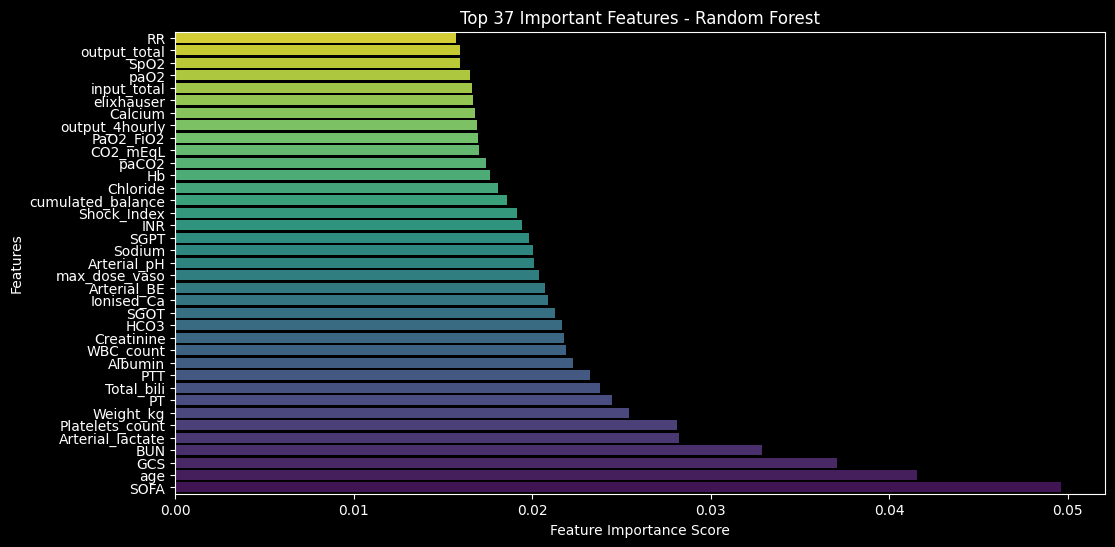

In [86]:
# Menentukan jumlah fitur teratas yang akan divisualisasikan
top_n = 37  # Jumlah fitur yang ingin ditampilkan dalam grafik (37 fitur teratas)

# Mengambil 37 fitur teratas berdasarkan peringkat pentingnya
top_features = feature_ranking.head(top_n)

# Membuat visualisasi bar chart untuk menampilkan pentingnya fitur
plt.figure(figsize=(12, 6))  # Menentukan ukuran gambar grafik
sns.barplot(x=top_features["Importance"], y=top_features["Feature"], palette="viridis")  # Membuat barplot menggunakan seaborn
plt.xlabel("Feature Importance Score")  # Label sumbu x untuk menunjukkan skor pentingnya fitur
plt.ylabel("Features")  # Label sumbu y untuk menunjukkan nama fitur
plt.title(f"Top {top_n} Important Features - Random Forest")  # Judul grafik
plt.gca().invert_yaxis()  # Membalikkan sumbu y agar fitur dengan pentingnya paling tinggi berada di atas
plt.show()  # Menampilkan grafik
